In [154]:
from glob import glob
import os
import csv
from pathlib import Path
from enum import Enum
import json
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [155]:
DEPENDENCIES_BY_AUTOMATON = '../experiments/find-dependencies/by-automaton/'
DEPENDENCIES_BY_FORMULA = '../experiments/find-dependencies/by-formula/'

# Load Experiment Results

In [156]:
def get_benchmark_name(idx):
    path = "../tools/scripts/benchmarks/{}.txt".format(idx)
    with open(path, 'r') as file:
        name = file.readline().replace("\n", "")
    return name
print(get_benchmark_name(2))

EnemeyModule


In [157]:

def csv_to_dict_list(file_name):
    with open(file_name, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        dict_list = list(reader)
    return dict_list

general_benchmarks = csv_to_dict_list("../tools/scripts/benchmarks.csv")
def get_benchmark_group(name):
    for benchmark in general_benchmarks:
        if benchmark['benchmark_name'] == name:
            return benchmark['group_name']
    return None

In [158]:
class Status(Enum):
    ERROR = "Error"
    SUCCESS = "Success"
    NOT_FOUND = "Not Found"
    TIMEOUT = "Timeout"
    
    def __repr__(self):
        return str(self.value)
    
    def __str__(self):
        return str(self.value)

In [159]:
class Algorithm(Enum):
    AUTOMATON = "Automaton"
    FORMULA = "Formula"
    
    def __repr__(self):
        return str(self.value)
    
    def __str__(self):
        return str(self.value)

In [160]:
def get_all_benchmarks(path):
    hoa_files = glob(os.path.join(path, "*.hoa"))
    names = [
        Path(f).stem
        for f in hoa_files
    ]
    return names

print("Total benchmark of finding dependencies by automaton" , len(get_all_benchmarks(DEPENDENCIES_BY_AUTOMATON)))
print("Total benchmark of finding dependencies by formula" , len(get_all_benchmarks(DEPENDENCIES_BY_FORMULA)))

Total benchmark of finding dependencies by automaton 562
Total benchmark of finding dependencies by formula 564


In [161]:
def benchmark_loader(algorithm: Algorithm, path: str):
    def load_benchmark(idx: str):
        base = {
            'id': int(idx),
            'Name': get_benchmark_name(idx),
        }

        hoa_path = os.path.join(path, idx + ".hoa")
        json_path = os.path.join(path, idx + ".json")

        if not os.path.exists(hoa_path):
            return {
                **base,
                'Status': Status.NOT_FOUND
            }

        if not os.path.exists(json_path):
            with open(hoa_path, 'r') as f:
                content = f.readlines()
                if 'DUE TO TIME LIMIT' in "\n".join(content):
                    return {
                        **base,
                        'Status': Status.TIMEOUT,
                    }

                return {
                    **base,
                    'Status': Status.ERROR,
                    'Error': content[0] if len(content) > 0 else 'HOA FILE IS EMPTY'

                }

        with open(json_path, 'r') as f:
            content = "\r\n".join(f.readlines())
            try:
                benchmark_json = json.loads(content)
            except Exception as e:
                return {
                    **base,
                    'Status': Status.ERROR,
                    'Error': content
                }
        
        if benchmark_json['dependency']["dependency_approach"] != algorithm.value.lower():
            raise Exception("Algorithm mismatch")

        is_completed = benchmark_json['is_completed']
        total_time = benchmark_json['total_time']
        output_vars = benchmark_json['output_vars']
        input_vars = benchmark_json['input_vars']
        is_automaton_built = benchmark_json['automaton']['is_built']
        automaton_build_duration = benchmark_json['automaton'].get('build_duration', None)
        total_states = benchmark_json['automaton'].get('total_states', None) if is_automaton_built else None
        total_edges = benchmark_json['automaton'].get('total_edges', None) if is_automaton_built else None

        base = {
            **base,
            'Is Completed': is_completed,
            'Total Duration': total_time,
            'Total Output Vars': len(output_vars),
            'Total Input Vars': len(input_vars),
            'Output Vars': output_vars,
            'Input Vars': input_vars,
            'is Automaton Built': is_automaton_built,
            'Automaton Build Duration': automaton_build_duration,
            'Total States': total_states,
            'Total Edges': total_edges,
        }

        if not is_completed:
            return {
                **base,
                'Status': Status.TIMEOUT,
            }

        if algorithm == Algorithm.AUTOMATON:
            total_pair_states = benchmark_json['dependency']['total_pair_state']
            search_pair_states_duration = benchmark_json['dependency']['search_pair_state_duration']
        else:
            total_pair_states, search_pair_states_duration = None, None
        
        dependent_vars = []
        independent_vars = []
        
        for var_description in benchmark_json["dependency"]['tested_dependencies']:
            if var_description['is_dependent']:
                dependent_vars.append(var_description['name'])
            else:
                independent_vars.append(var_description['name'])
        
        return {
            **base,
            'Status': Status.SUCCESS,
            'Total Dependents': len(dependent_vars),
            'Dependency Ratio': len(dependent_vars) / len(output_vars),

            'Total Pair States': total_pair_states,
            'Search Pair States Duration': search_pair_states_duration,

            'Dependent Vars': dependent_vars,
            'Independent Vars': independent_vars,
        }

    return load_benchmark

## Load benchmarks by Automaton

In [177]:
by_automaton_loader = benchmark_loader(Algorithm.AUTOMATON, DEPENDENCIES_BY_AUTOMATON)
by_automaton_df = pd.DataFrame([by_automaton_loader(name) for name in get_all_benchmarks(DEPENDENCIES_BY_AUTOMATON)])
by_automaton_df.set_index("id", inplace=True)
by_automaton_df

,Name,Is Completed,Total Duration,Total Output Vars,Total Input Vars,Output Vars,Input Vars,is Automaton Built,Automaton Build Duration,Total States,Total Edges,Status,Total Dependents,Dependency Ratio,Total Pair States,Search Pair States Duration,Dependent Vars,Independent Vars,Error
id,,,,,,,,,,,,,,,,,,,
208,CheckCoffeMachine_3461125b,True,20.0,4.0,4.0,"[u0cm29ctrl0f1dturn2off1b, u0cm29ctrl0f1dmake2...","[p0b0cm29finished, p0b0cm29busy, p0b0cm29stand...",True,19.0,10.0,34.0,Success,1.0,0.250000,24.0,0.0,[u0cm29ctrl0cm29ctrl],"[u0cm29ctrl0f1dturn2on1b, u0cm29ctrl0f1dmake2c...",NaN
234,CoffeMachine_974f4a68,True,42.0,4.0,6.0,"[u02c2m29ctrl0f1d2c2m29turn2off1b, u02c2m29ctr...","[p0p0standby02c2m29intend, p0p0ready02c2m29int...",True,37.0,20.0,85.0,Success,1.0,0.250000,122.0,0.0,[u02c2m29ctrl02c2m29ctrl],"[u02c2m29ctrl0f1d2c2m29turn2on1b, u02c2m29ctrl...",NaN
552,ltl2dba_beta,True,13.0,1.0,4.0,[acc],"[q_0, q_1, p_0, p_1]",True,12.0,19.0,74.0,Success,0.0,0.000000,120.0,0.0,[],[acc],NaN
546,ltl2dba24,True,5.0,1.0,1.0,[acc],[p],True,5.0,4.0,8.0,Success,0.0,0.000000,5.0,0.0,[],[acc],NaN
220,Timer_a50cadd7,True,38.0,4.0,1.0,"[u0system29start2new2timer0f1dhour251b, u0syst...",[p0b0timeout],True,7.0,2.0,4.0,Success,1.0,0.250000,2.0,0.0,[u0system29start2new2timer0system29start2new2t...,"[u0system29start2new2timer0f1dmin25231b, u0sys...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,TwoCountersInRangeA3,True,3762.0,8.0,11.0,"[u0selected0f1dtoggle0selected1b, u0selected0s...","[p0p0second0selected, p0p0in2range0f1dincremen...",True,3758.0,6.0,13.0,Success,3.0,0.375000,16.0,0.0,"[u0first2counter0first2counter, u0second2count...","[u0first2counter0f1ddecrement0first2counter1b,...",NaN
239,AllLights_63831f8c,True,49305.0,8.0,12.0,[u02roomlight29light0f1d2roomlight29turn2off1b...,"[p0p0bright0outside29brightness, p0b0bed29occu...",True,46130.0,112.0,2283.0,Success,2.0,0.250000,1422.0,77.0,[u02timer29start2new2timer02timer29start2new2t...,[u02timer29start2new2timer0f1d2timer29min25231...,NaN
205,Lights_3461125b,True,73.0,4.0,6.0,"[u0room29light0f1dturn2off1b, u0room29light0f1...","[p0b0room29light29off, p0b0room29light29on, p0...",True,58.0,11.0,31.0,Success,1.0,0.250000,52.0,0.0,[u0room29light0room29light],"[u0room29light0f1dturn2on1b, u0room29light0f1d...",NaN


### Analysing Errors

In [163]:
by_automaton_df[by_automaton_df["Status"] == Status.ERROR][["Name", "Status", "Error"]]

,Name,Status,Error
id,,,
486,12,Error,Runtime error: Too many acceptance sets used. ...
487,08,Error,Runtime error: Too many acceptance sets used. ...
491,10,Error,Runtime error: Too many acceptance sets used. ...
485,13,Error,Runtime error: Too many acceptance sets used. ...
484,05,Error,Runtime error: Too many acceptance sets used. ...
490,06,Error,Runtime error: Too many acceptance sets used. ...
483,09,Error,Runtime error: Too many acceptance sets used. ...
489,07,Error,Runtime error: Too many acceptance sets used. ...
488,11,Error,Runtime error: Too many acceptance sets used. ...


In [178]:
by_automaton_df[(by_automaton_df["Status"] == Status.TIMEOUT)]

,Name,Is Completed,Total Duration,Total Output Vars,Total Input Vars,Output Vars,Input Vars,is Automaton Built,Automaton Build Duration,Total States,Total Edges,Status,Total Dependents,Dependency Ratio,Total Pair States,Search Pair States Duration,Dependent Vars,Independent Vars,Error
id,,,,,,,,,,,,,,,,,,,
80,TwoCountersDisButA8,False,3599996.0,13.0,14.0,"[u0window0f1denable2button0up1b, u0window0f1de...","[p0p0second0selected, p0p0in2range0f1dincremen...",False,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,amba_gr+_6,False,3599995.0,26.0,15.0,"[req_ready, stateg10_5, stateg10_4, stateg10_3...","[hburst1, hburst0, hlock5, hbusreq5, hlock4, h...",False,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,TwoCountersDisButA9,False,3599997.0,13.0,14.0,"[u0window0f1denable2button0up1b, u0window0f1de...","[p0p0second0selected, p0p0in2range0f1dincremen...",False,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,amba_gr+_11,False,3599995.0,37.0,25.0,"[req_ready, stateg10_10, stateg10_9, stateg10_...","[hburst1, hburst0, hlock10, hbusreq10, hlock9,...",False,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,Full_f1477cc5,False,3599996.0,30.0,36.0,"[u0music29ctrl0f1dplay0f1doverture1b1b, u0musi...",[p0p0gt0outside29temperature0room29temperature...,False,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,Morning2_407db2cc,False,3599996.0,10.0,18.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,"[p0p02time29between02time29pm702time29pm8, p0p...",False,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204,Morning_c92eb242,False,3599996.0,15.0,14.0,"[u0tv29ctrl0f1dturn2on1b, u0tv29ctrl0tv29ctrl,...","[p0p02time29between02time29pm702time29pm8, p0p...",False,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,Morning2_63831f8c,False,3599996.0,10.0,21.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,[p0p02time29between0p1db02time29pm71b02time29p...,False,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN


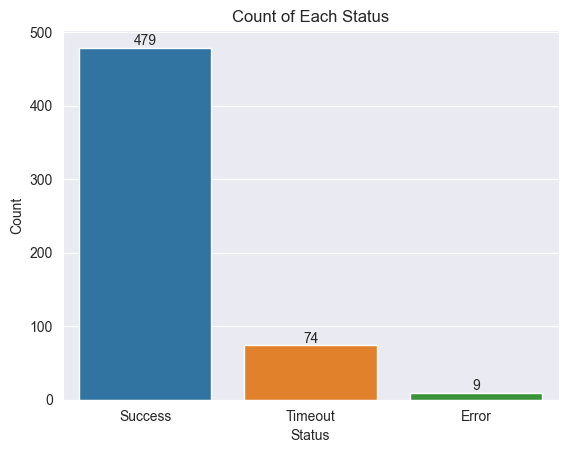

In [179]:
tmp_df = by_automaton_df.copy()
tmp_df["Status"] = tmp_df["Status"].astype(str)
ax = sns.countplot(data=tmp_df, x="Status")
ax.bar_label(ax.containers[0])
plt.title('Count of Each Status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

## Load benchmarks by Formula

In [180]:
by_formula_loader = benchmark_loader(Algorithm.FORMULA, DEPENDENCIES_BY_FORMULA)
by_formula_df = pd.DataFrame([by_formula_loader(name) for name in get_all_benchmarks(DEPENDENCIES_BY_FORMULA)])
by_formula_df.set_index("id", inplace=True)
by_formula_df.head(5)

,Name,Is Completed,Total Duration,Total Output Vars,Total Input Vars,Output Vars,Input Vars,is Automaton Built,Automaton Build Duration,Total States,Total Edges,Status,Total Dependents,Dependency Ratio,Total Pair States,Search Pair States Duration,Dependent Vars,Independent Vars,Error
id,,,,,,,,,,,,,,,,,,,
208,CheckCoffeMachine_3461125b,True,12113.0,4.0,4.0,"[u0cm29ctrl0f1dturn2off1b, u0cm29ctrl0f1dmake2...","[p0b0cm29finished, p0b0cm29busy, p0b0cm29stand...",True,20.0,10.0,6.943010e+08,Success,1.0,0.25,NaN,NaN,[u0cm29ctrl0cm29ctrl],"[u0cm29ctrl0f1dturn2on1b, u0cm29ctrl0f1dmake2c...",NaN
234,CoffeMachine_974f4a68,False,3599996.0,4.0,6.0,"[u02c2m29ctrl0f1d2c2m29turn2off1b, u02c2m29ctr...","[p0p0standby02c2m29intend, p0p0ready02c2m29int...",True,32.0,20.0,1.819440e+09,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
552,ltl2dba_beta,False,3599997.0,1.0,4.0,[acc],"[q_0, q_1, p_0, p_1]",True,10.0,19.0,3.300000e+01,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,ltl2dba24,True,15.0,1.0,1.0,[acc],[p],True,5.0,4.0,0.000000e+00,Success,0.0,0.00,NaN,NaN,[],[acc],NaN
220,Timer_a50cadd7,True,51.0,4.0,1.0,"[u0system29start2new2timer0f1dhour251b, u0syst...",[p0b0timeout],True,8.0,2.0,1.936028e+09,Success,1.0,0.25,NaN,NaN,[u0system29start2new2timer0system29start2new2t...,"[u0system29start2new2timer0f1dmin25231b, u0sys...",NaN


In [181]:
by_formula_df[by_formula_df["Status"] == Status.ERROR]

,Name,Is Completed,Total Duration,Total Output Vars,Total Input Vars,Output Vars,Input Vars,is Automaton Built,Automaton Build Duration,Total States,Total Edges,Status,Total Dependents,Dependency Ratio,Total Pair States,Search Pair States Duration,Dependent Vars,Independent Vars,Error
id,,,,,,,,,,,,,,,,,,,
427,Demo1_06e9cad4_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Error,NaN,NaN,NaN,NaN,NaN,NaN,Error occurred: std::bad_alloc\n
223,Lights_06e9cad4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Error,NaN,NaN,NaN,NaN,NaN,NaN,Error occurred: std::bad_alloc\n
380,Full_f1477cc5_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Error,NaN,NaN,NaN,NaN,NaN,NaN,Error occurred: std::bad_alloc\n
430,Demo1_06e9cad4_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Error,NaN,NaN,NaN,NaN,NaN,NaN,Error occurred: std::bad_alloc\n
3,KitchenTimerV4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Error,NaN,NaN,NaN,NaN,NaN,NaN,Error occurred: std::bad_alloc\n
386,Demo1_2c5b09da_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Error,NaN,NaN,NaN,NaN,NaN,NaN,Error occurred: std::bad_alloc\n
47,KitchenTimerV3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Error,NaN,NaN,NaN,NaN,NaN,NaN,Error occurred: std::bad_alloc\n
486,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Error,NaN,NaN,NaN,NaN,NaN,NaN,Runtime error: Too many acceptance sets used. ...
487,08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Error,NaN,NaN,NaN,NaN,NaN,NaN,Runtime error: Too many acceptance sets used. ...


In [182]:
by_formula_df[by_formula_df["Status"] == Status.TIMEOUT]

,Name,Is Completed,Total Duration,Total Output Vars,Total Input Vars,Output Vars,Input Vars,is Automaton Built,Automaton Build Duration,Total States,Total Edges,Status,Total Dependents,Dependency Ratio,Total Pair States,Search Pair States Duration,Dependent Vars,Independent Vars,Error
id,,,,,,,,,,,,,,,,,,,
234,CoffeMachine_974f4a68,False,3599996.0,4.0,6.0,"[u02c2m29ctrl0f1d2c2m29turn2off1b, u02c2m29ctr...","[p0p0standby02c2m29intend, p0p0ready02c2m29int...",True,32.0,20.0,1.819440e+09,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
552,ltl2dba_beta,False,3599997.0,1.0,4.0,[acc],"[q_0, q_1, p_0, p_1]",True,10.0,19.0,3.300000e+01,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,TwoCountersDisButA8,False,3599996.0,13.0,14.0,"[u0window0f1denable2button0up1b, u0window0f1de...","[p0p0second0selected, p0p0in2range0f1dincremen...",False,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,amba_gr+_6,False,3599995.0,26.0,15.0,"[req_ready, stateg10_5, stateg10_4, stateg10_3...","[hburst1, hburst0, hlock5, hbusreq5, hlock4, h...",False,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156,mux,False,3599855.0,1.0,14.0,[out],"[in_0, in_1, in_2, in_3, in_4, in_5, in_6, in_...",True,7.0,1.0,1.702196e+09,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,Cockpitboard,False,3599996.0,19.0,6.0,"[u0ycoord0f1dinc2coord0ycoord1b, u0ycoord0ycoo...",[p0p0hitcoord0xcoord0ycoord0f1dgetenemyradius0...,True,5.0,1.0,6.737183e+08,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,lilydemo06,False,3600006.0,1.0,3.0,[grant],"[go, cancel, req]",True,12.0,20.0,6.732177e+08,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,TwoCountersInRangeA3,False,3599996.0,8.0,11.0,"[u0selected0f1dtoggle0selected1b, u0selected0s...","[p0p0second0selected, p0p0in2range0f1dincremen...",True,5055.0,6.0,1.936878e+09,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Analysing by Status

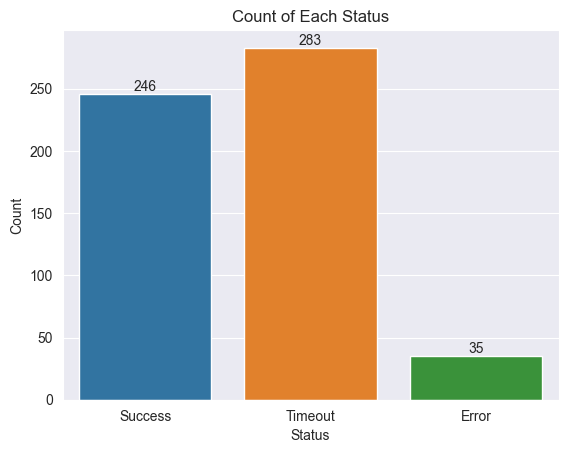

In [183]:
tmp_df = by_formula_df.copy()
tmp_df["Status"] = tmp_df["Status"].astype(str)
ax = sns.countplot(data=tmp_df, x="Status")
ax.bar_label(ax.containers[0])
plt.title('Count of Each Status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

# By Formula vs By Automaton

In [184]:
common_fields = ["name", "status", "is_completed", "total_time", "dependent_vars"]

dependency_df = pd.merge(
    by_automaton_df[common_fields],
    by_formula_df[common_fields],
    on=["id", "name"],
    suffixes=("_automaton", "_formula")
)
dependency_df

KeyError: "None of [Index(['name', 'status', 'is_completed', 'total_time', 'dependent_vars'], dtype='object')] are in the [columns]"

### Sanity Check - Same dependent variables

In [108]:
tmp_df = dependency_df[(dependency_df["is_completed_automaton"] == True) & (dependency_df["is_completed_formula"] == True)]
tmp_df[tmp_df["dependent_vars_formula"] != tmp_df["dependent_vars_automaton"]][["name", "dependent_vars_formula", "dependent_vars_automaton"]]
# tmp_df[tmp_df["id_automaton"] == "389"]

,name,dependent_vars_formula,dependent_vars_automaton
id,,,
389,test2_f2774e0b_1,"[u0a0a, u0a0f1dc251b, u0b0b, u0c0c, u0c0f1dc31b]","[u0a0a, u0a0f1dc251b, u0b0b, u0c0c, u0c0f1dc31..."


# Dependency Prevelance

In [111]:
by_automaton_df = by_automaton_df[(by_automaton_df["is_completed"] == True) & (by_automaton_df["status"] == Status.SUCCESS)]
by_formula_df = by_formula_df[(by_formula_df["is_completed"] == True) & (by_formula_df["status"] == Status.SUCCESS)]

/var/folders/zb/bf8vj3b90bs7gkm2bn4lsfqm0000gn/T/ipykernel_2303/3936170162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  by_automaton_df["has_dependents"] = by_automaton_df["total_dependents"] > 0


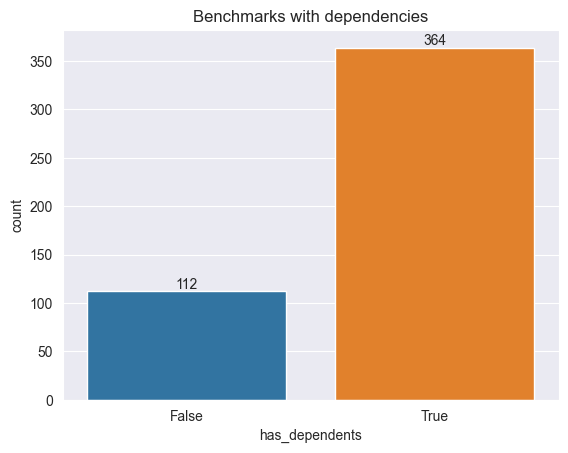

In [110]:
by_automaton_df["has_dependents"] = by_automaton_df["total_dependents"] > 0
ax = sns.countplot(data=by_automaton_df, x='has_dependents')
ax.bar_label(ax.containers[0]);
ax.set_title("Benchmarks with dependencies");

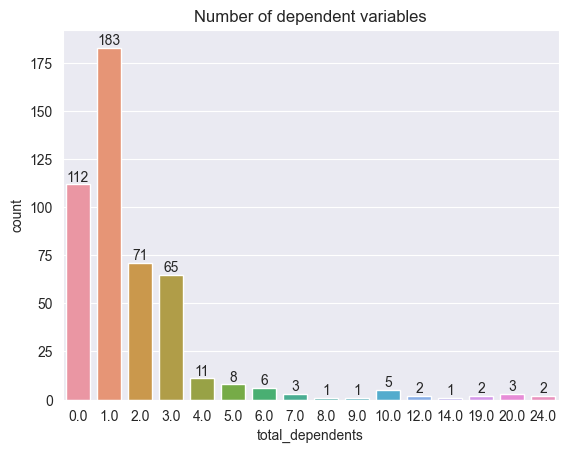

In [63]:
ax = sns.countplot(data=by_automaton_df, x='total_dependents')
ax.bar_label(ax.containers[0]);
ax.set_title("Number of dependent variables");

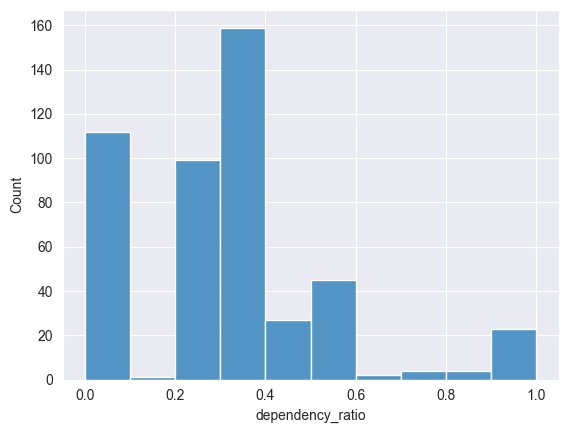

In [64]:
sns.histplot(data=by_automaton_df, x='dependency_ratio', bins=10);

In [65]:
dependency_df = pd.merge(
    by_automaton_df,
    by_formula_df,
    on="name",
    suffixes=("_automaton", "_formula")
)
dependency_df
dependency_df.to_csv('./dependency_df.csv')